In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pprint

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score,\
    recall_score, roc_auc_score, roc_curve, confusion_matrix, auc

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

In [2]:
with open('specphoto.pickle', 'rb') as f:
    sp = pickle.load(f)
    f.close()
print(sp.shape)
sp.head()

(3229302, 16)


,objid,specobjid,class,ra,dec,redshift,u,g,r,i,z,spectroflux_u,spectroflux_g,spectroflux_r,spectroflux_i,spectroflux_z
0,1237648704604471436,409948271046322176,STAR,245.921,0.157,-7.844e-04,19.216,17.863,17.978,18.078,18.147,61.115,70.773,62.103,55.950,48.844
1,1237648703520309420,346818705755236352,GALAXY,222.089,-0.808,5.623e-02,17.640,16.237,15.523,15.124,14.835,12.104,34.624,80.142,123.595,160.425
2,1237651752387412385,304085365851973632,GALAXY,151.934,1.038,1.824e-01,19.828,18.342,17.329,16.841,16.518,3.544,7.320,19.664,31.217,42.924
3,1237648722316951761,338988538395650048,GALAXY,208.536,0.770,1.029e-01,20.330,18.443,17.516,17.087,16.781,5.858,18.773,49.093,72.477,96.514
4,1237668567710564584,387390135584450560,GALAXY,240.171,-0.962,1.570e-01,21.372,19.013,17.630,17.063,16.616,4.980,13.064,42.098,69.338,99.163


In [3]:
sp.describe()

,objid,specobjid,ra,dec,redshift,u,g,r,i,z,spectroflux_u,spectroflux_g,spectroflux_r,spectroflux_i,spectroflux_z
count,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06,3.229e+06
mean,1.238e+18,4.171e+18,1.738e+02,2.400e+01,5.181e-01,2.179e+01,2.018e+01,1.921e+01,1.862e+01,1.830e+01,1.106e+01,2.370e+01,4.366e+01,5.967e+01,7.323e+01
std,8.268e+12,3.433e+18,9.099e+01,1.939e+01,6.890e-01,3.012e+01,2.738e+01,1.712e+00,1.856e+01,2.092e+01,4.002e+01,7.377e+01,1.178e+02,1.467e+02,1.703e+02
min,1.238e+18,-9.223e+18,9.458e-05,-1.970e+01,-1.042e-02,-9.999e+03,-9.999e+03,1.110e+01,-9.999e+03,-9.999e+03,-5.033e+01,-7.912e+00,-2.640e+01,-7.075e+01,-1.703e+02
25%,1.238e+18,2.162e+18,1.298e+02,7.134e+00,5.478e-02,2.001e+01,1.857e+01,1.773e+01,1.733e+01,1.707e+01,3.864e-01,9.382e-01,3.504e+00,7.229e+00,1.071e+01
50%,1.238e+18,4.757e+18,1.765e+02,2.251e+01,3.602e-01,2.189e+01,2.065e+01,1.957e+01,1.897e+01,1.861e+01,1.949e+00,3.826e+00,9.419e+00,1.518e+01,2.096e+01
75%,1.238e+18,6.712e+18,2.244e+02,3.938e+01,5.858e-01,2.357e+01,2.186e+01,2.061e+01,1.980e+01,1.941e+01,7.946e+00,1.888e+01,3.909e+01,5.639e+01,7.080e+01
max,1.238e+18,9.223e+18,3.600e+02,8.485e+01,7.043e+00,3.078e+01,2.887e+01,2.480e+01,2.985e+01,3.002e+01,4.844e+03,9.465e+03,2.098e+04,2.859e+04,2.877e+04


In [4]:
def compute_metrics(model_fit, test_x, test_y):
    """
    Takes a classification model fit using sklearn, a test set
    prediction matrix, and the test set responses (labels), and 
    returns a dictionary with the computed accuracy, f1 score, 
    precision, recall, log-loss, and AUC score (for the ROC curve).
    
    Parameters
    -----------
    model_fit: sklearn classification model fit
    test_x: dataframe of predictor values for test data
    test_y: one-dimensional array or dataframe with test data labels
    
    Returns
    --------
    dictionary with six calculated model evaluation metrics
    """
    
    pred = model_fit.predict(test_x)
    prob = model_fit.predict_proba(test_x)
    
    acc = accuracy_score(test_y, pred)
    logloss = log_loss(test_y, prob)
    
    if test_y.nunique() > 2:
        f1 = f1_score(test_y, pred, average = 'weighted')
        prec = precision_score(test_y, pred, average = 'weighted')
        rec = recall_score(test_y, pred, average = 'weighted')
        auc = roc_auc_score(label_binarize(test_y, classes = list(model_fit.classes_)), 
                            prob, average = 'weighted')
        
    else:
        f1 = f1_score(test_y, pred, average = 'binary')
        prec = precision_score(test_y, pred, average = 'binary')
        rec = recall_score(test_y, pred, average = 'binary')
        auc = roc_auc_score(test_y, prob[:,1])
    
    return {'accuracy': acc, 'f1_score': f1, 'precision': prec, 
            'recall': rec, 'log_loss': logloss, 'auc': auc}

In [5]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize = 18):
    """
    Takes a confusion matrix as returned by sklearn.metrics.confusion_matrix and returns it
    as a heatmap.
    
    Parameters
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order that they index the given confusion matrix.
    figsize: tuple
        A 2-tuple, the first value determining the horizontal size of the output figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axis labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix heatmap
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names, )
    plt.figure(figsize = figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap = 'viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, 
                                 ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, 
                                 ha = 'right', fontsize = fontsize)
    plt.ylabel('True label', fontsize = 15, style = 'italic')
    plt.xlabel('Predicted label', fontsize = 15, style = 'italic')
    
    plt.show()
    plt.close()

In [6]:
def roc_curve_multiclass(OVR_model_fit, X, y):
    """
    Takes a one-vs-rest (OVR) multiclass classification model fit using sklearn, 
    a prediction matrix, and a response vector (labels), and returns a series of ROC
    curves corresponding to each class, with the AUC score shown in the lower-right.
    Note that some model types (e.g. logistic regression, naive bayes, support vector 
    machines, decision trees) support OVR classification by default. Others (e.g. kNN)
    need to be coerced with sklearn.multiclass.OneVsRestClassifier.
    
    Parameters
    -----------
    OVR_model_fit: sklearn classification model fit using one-vs-rest classification
    X: dataframe of predictor values
    y: one-dimensional array or dataframe with labels
    
    Returns
    --------
    A series of stacked independent ROC curves, one for each class. The number of curves 
    will equal the number of response classes. The AUC score for each curve is shown in 
    the lower-right legend. 
    """
    
    # Get 1-0 binary labels for each class
    y = label_binarize(y, classes = list(OVR_model_fit.classes_))
    n_classes = len(OVR_model_fit.classes_)
    
    # Get predicted probabilities for test data
    y_score = OVR_model_fit.predict_proba(X)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot ROC curve for each class
    for i in range(n_classes):
        plt.figure(figsize = (8, 6))
        plt.plot(fpr[i], tpr[i], label = 'ROC Curve (area = %0.2f)' % roc_auc[i], 
                 color = 'darkred')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', style = 'italic', fontsize = 15)
        plt.ylabel('True Positive Rate', style = 'italic', fontsize = 15)
        plt.title('Receiver Operating Characteristic for {}'\
                  .format(OVR_model_fit.classes_[i]), fontsize = 18)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.legend(loc = "lower right")
        
        plt.show()
        plt.close()

In [7]:
# split train-test twice to get useable training set (reasonable size) for model building
# first split 20/80, then split training set 50/50 (10% of total data for both train and test)
# use stratified sampling due to class imbalance

X = sp.iloc[:, 5:]
y = sp.iloc[:, 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.80, 
                                                    random_state = 476, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.50, 
                                                    random_state = 476, stratify = y_train)

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(322930, 11) (322930, 11) (322930,) (322930,)


In [9]:
# baseline ('dummy') classifier - always predicts 'GALAXY'
dummy = DummyClassifier(strategy = 'most_frequent', random_state = 476).fit(X_train, y_train)
dummy_metrics = compute_metrics(dummy, X_test, y_test)
dummy_metrics

{'accuracy': 0.6154491685504598,
 'f1_score': 0.46894410105064344,
 'precision': 0.3787776790694523,
 'recall': 0.6154491685504598,
 'log_loss': 13.281915179912652,
 'auc': 0.5}

### Logistic Regression

In [10]:
# scale predictors 
scale = StandardScaler().fit(X_train)
X_tr = scale.transform(X_train)
X_te = scale.transform(X_test)

# fit logistic regression model on training set with 'lbfgs' solver and multinomial loss function
logit = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', 
                           random_state = 476).fit(X_tr, y_train)

# compute model evaluation metrics for model fit on test set
logit_metrics = compute_metrics(logit, X_te, y_test)
logit_metrics

{'accuracy': 0.9855107918124671,
 'f1_score': 0.9854040440173395,
 'precision': 0.9854902263955835,
 'recall': 0.9855107918124671,
 'log_loss': 0.05624781670976056,
 'auc': 0.9963895837786987}

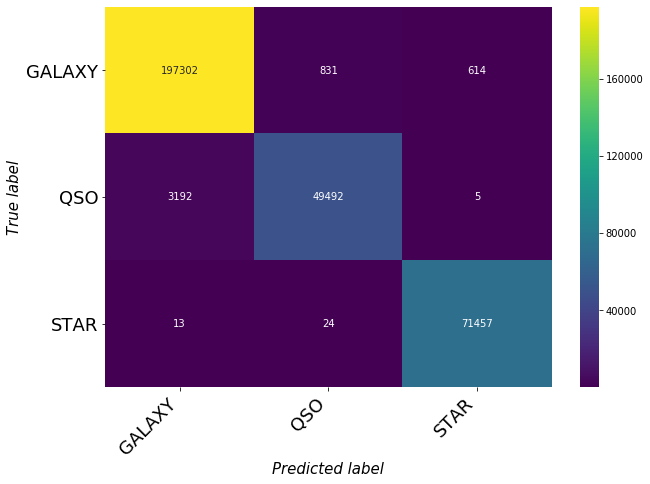

In [10]:
# compute confusion matrix and plot as heatmap
logit_cm = confusion_matrix(y_test, logit.predict(X_te), labels = logit.classes_)
print_confusion_matrix(logit_cm, ['GALAXY', 'QSO', 'STAR'])

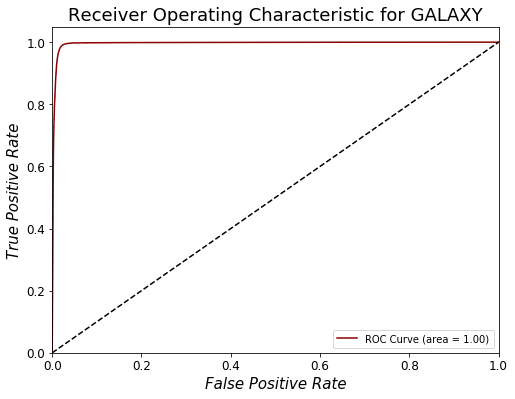

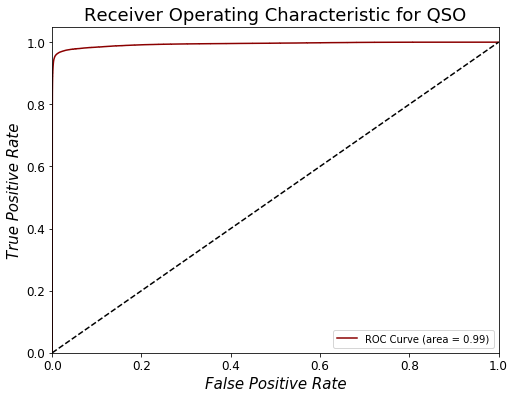

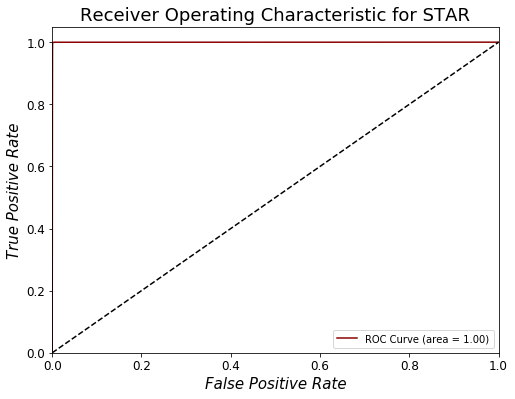

In [11]:
# plot ROC curves for each class (one-vs-rest)
roc_curve_multiclass(logit, X_te, y_test)

In [13]:
# print logistic regression coefficients for each class
# since predictors were scaled, magnitude indicates predictor weight and sign indicates 
# direction of effect on class probability
pprint.pprint(list(zip(logit.classes_, logit.coef_)))

[('GALAXY',
  array([24.96629283,  5.67987543,  7.29102747,  0.82617989, -2.83958082,
       -0.3470368 , -1.59796748,  1.46890322,  1.92289446, -3.57078057,
        1.05189597])),
 ('QSO',
  array([ 29.50418401, -12.99994954,  -6.1317835 ,  -4.45115732,
         3.28187767,   9.10908713,   1.78848928,  -3.22505984,
        -2.5238767 ,   3.80215193,  -1.14581833])),
 ('STAR',
  array([-54.47047685,   7.32007411,  -1.15924397,   3.62497743,
        -0.44229685,  -8.76205032,  -0.1905218 ,   1.75615663,
         0.60098224,  -0.23137136,   0.09392236]))]


### k-Nearest Neighbors

In [23]:
k = 10

#Setup k-fold CV method
kf = KFold(n_splits = k, shuffle = True, random_state = 476)

In [24]:
# use 10-fold CV on training set to find optimal k for kNN model
k_list = np.arange(1, 21)   # 20 different values of k
knn_acc = {}
knn_f1 = {}
knn_prec = {}
knn_rec = {}

for k in k_list:
    
    # initialize kNN model
    knn = KNeighborsClassifier(n_neighbors = k)
    acc_list = []
    f1_list = []
    prec_list = []
    rec_list = []
    
    for tr, val in kf.split(X_train, y_train):
        
        # split into training and validation sets for each fold
        X_tr, X_val = X_train.iloc[tr], X_train.iloc[val]
        y_tr, y_val = y_train.iloc[tr], y_train.iloc[val]
        
        #scale predictors
        scale = StandardScaler()
        scale.fit(X_tr)

        X_tr = scale.transform(X_tr)
        X_val = scale.transform(X_val)
        
        #fit kNN model on training set and predict on validation set
        knn.fit(X_tr, y_tr)
        pred = knn.predict(X_val)
        
        #compute accuracy, f1 score, precision, and recall for predictions
        acc_list.append(accuracy_score(y_val, pred))
        f1_list.append(f1_score(y_val, pred, average = 'weighted'))
        prec_list.append(precision_score(y_val, pred, average = 'weighted'))
        rec_list.append(recall_score(y_val, pred, average = 'weighted'))
    
    # take mean of each metric across all 10 folds
    knn_acc[k] = np.mean(acc_list)
    knn_f1[k] = np.mean(f1_list)
    knn_prec[k] = np.mean(prec_list)
    knn_rec[k] = np.mean(rec_list)

# compile results into dataframe with each value of k as columns
pd.DataFrame([knn_acc, knn_f1, knn_prec, knn_rec], 
             index = ['accuracy', 'f1_score', 'precision', 'recall'])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy,0.987,0.989,0.99,0.99,0.99,0.99,0.99,0.99,0.990,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989
f1_score,0.987,0.989,0.99,0.99,0.99,0.99,0.99,0.99,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989
precision,0.987,0.989,0.99,0.99,0.99,0.99,0.99,0.99,0.990,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989
recall,0.987,0.989,0.99,0.99,0.99,0.99,0.99,0.99,0.990,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989


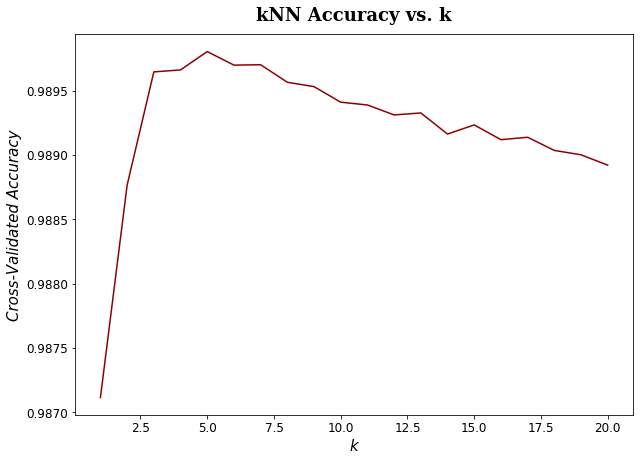

In [25]:
# plot CV accuracy vs. k
plt.figure(figsize = (10, 7))
plt.plot(k_list, list(knn_acc.values()), color = 'darkred')
plt.title("kNN Accuracy vs. k", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('k', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated Accuracy', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

plt.savefig('knn_objects_cv.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [11]:
# scale predictors
scale = StandardScaler().fit(X_train)
X_tr = scale.transform(X_train)
X_te = scale.transform(X_test)

# fit kNN model to whole training set with optimal k
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_tr, y_train)
knn_metrics = compute_metrics(knn, X_te, y_test)
knn_metrics

{'accuracy': 0.9896695878363732,
 'f1_score': 0.9896167116993235,
 'precision': 0.9896729171156566,
 'recall': 0.9896695878363732,
 'log_loss': 0.1974272126981302,
 'auc': 0.9933837933613193}

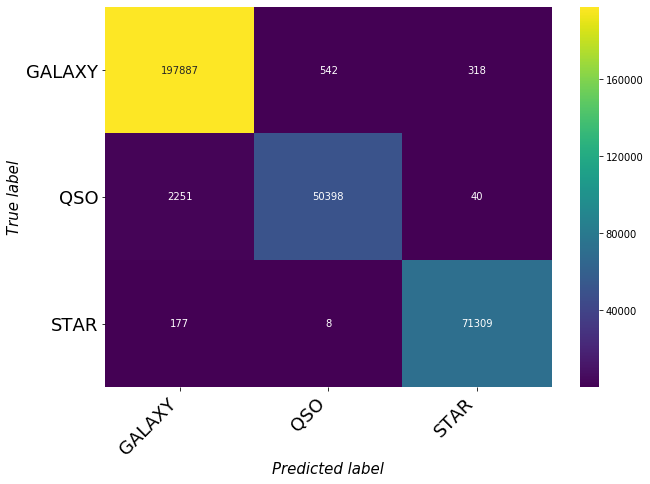

In [18]:
# kNN confusion matrix
knn_cm = confusion_matrix(y_test, knn.predict(X_te))
print_confusion_matrix(knn_cm, ['GALAXY', 'QSO', 'STAR'])

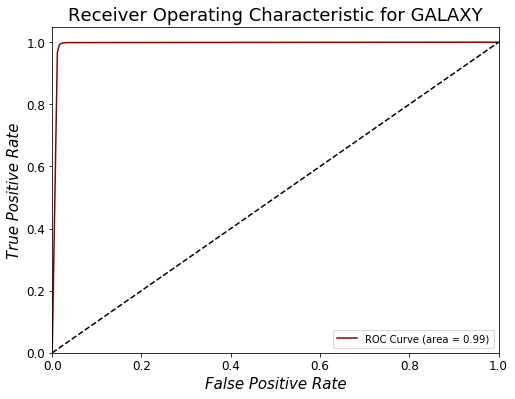

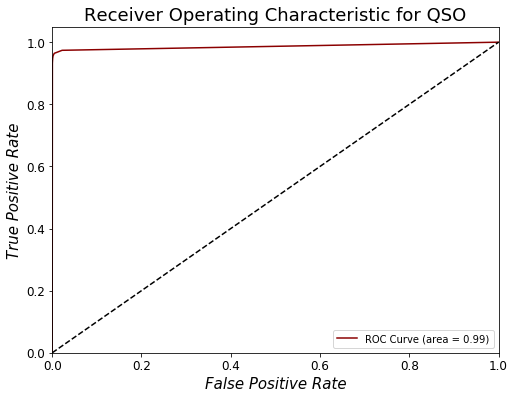

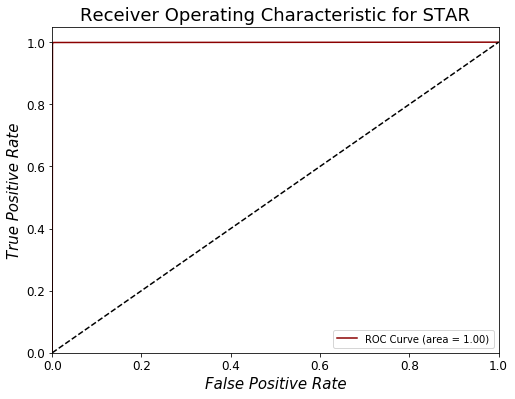

In [227]:
# coerce kNN model to one-vs-rest classifier for ROC curves
knn_ovr = OneVsRestClassifier(knn).fit(X_tr, y_train)
roc_curve_multiclass(knn_ovr, X_te, y_test)

### Naive Bayes

In [12]:
# fit naive bayes classifier to training set and evaluate with test set
nb = GaussianNB().fit(X_train, y_train)
nb_metrics = compute_metrics(nb, X_test, y_test)
nb_metrics

{'accuracy': 0.8079367045489735,
 'f1_score': 0.7800413477050201,
 'precision': 0.835232763162132,
 'recall': 0.8079367045489735,
 'log_loss': 2.0505408398005995,
 'auc': 0.8936549792997294}

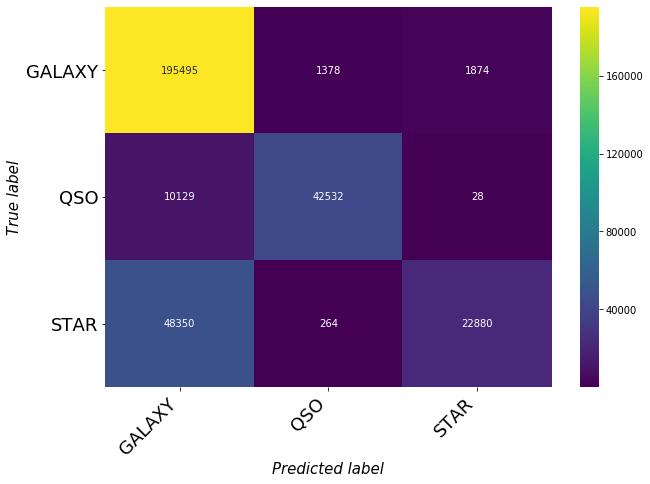

In [20]:
# naive bayes confusion matrix
nb_cm = confusion_matrix(y_test, nb.predict(X_test))
print_confusion_matrix(nb_cm, ['GALAXY', 'QSO', 'STAR'])

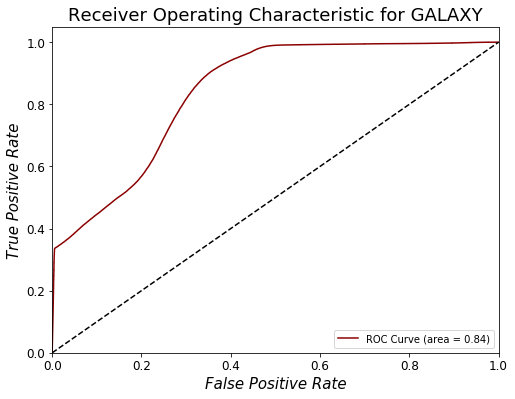

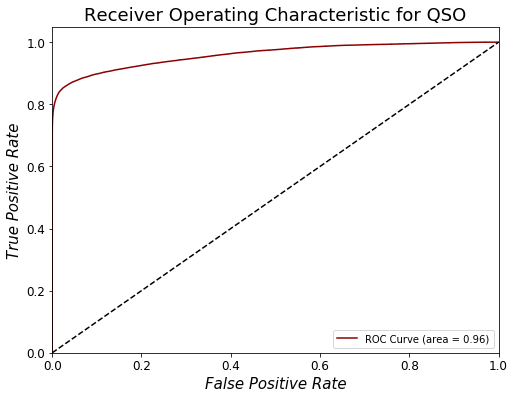

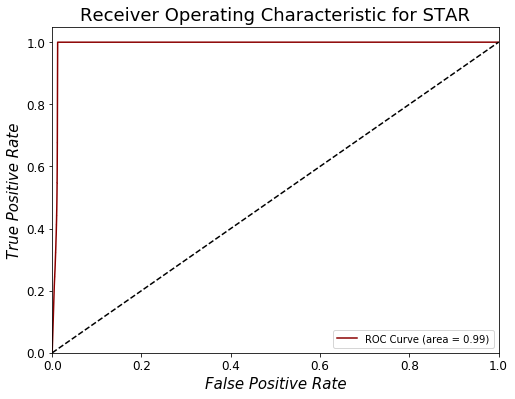

In [23]:
# plot ROC curve for each class
roc_curve_multiclass(nb, X_test, y_test)

In [25]:
list(zip(nb.classes_, nb.theta_))  # mean of each feature by class

[('GALAXY',
  array([ 0.37140984, 22.46297452, 20.56407343, 19.1571815 , 18.41924525,
         18.0209054 ,  3.46578157,  9.58065094, 24.19973408, 38.20642187,
         51.2603325 ])),
 ('QSO',
  array([ 1.77810223, 21.09030903, 20.41498676, 20.35929819, 20.20521336,
         20.04393903,  7.99013395,  9.3722433 , 11.69398206, 13.63650784,
         15.48050001])),
 ('STAR',
  array([-1.05367952e-04,  2.05291213e+01,  1.89958208e+01,  1.85037459e+01,
          1.81659203e+01,  1.78493334e+01,  3.43106190e+01,  7.34278619e+01,
          1.21355357e+02,  1.53422937e+02,  1.77271543e+02]))]

In [26]:
list(zip(nb.classes_, np.sqrt(nb.sigma_)))   # variance of each feature by class

[('GALAXY',
  array([ 0.21352706,  2.34200049,  2.03683369,  1.68564573,  1.44473487,
          1.38603523,  7.31267314, 19.11147628, 42.10192027, 61.19436629,
         79.31278419])),
 ('QSO',
  array([ 0.84883384, 43.67725115, 43.66311429,  1.06153153,  1.08514726,
          1.08517667, 16.8322213 , 16.63567801, 20.03779449, 24.98240246,
         27.92254488])),
 ('STAR',
  array([5.37688488e-03, 3.75366546e+01, 3.75141867e+01, 1.73790587e+00,
         1.66569096e+00, 3.75009076e+01, 7.79433446e+01, 1.41334919e+02,
         2.19898817e+02, 2.68732384e+02, 3.11836934e+02]))]

### Support Vector Classifier

In [14]:
# split data again for SVM (train and val are now each 5% of original data; test is 10%)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.50, 
                                                    random_state = 476, stratify = y_train)
print(X_train2.shape, X_val.shape, y_train2.shape, y_val.shape)

(161465, 11) (161465, 11) (161465,) (161465,)


In [28]:
# use train-test split to find optimal C for support vector classifier model
c_list = 10**np.linspace(-3, 2, 6)  # 6 different values of C covering 6 orders of magnitude
svc_acc = {}
svc_f1 = {}
svc_prec = {}
svc_rec = {}

# scale predictors
scale = StandardScaler()
scale.fit(X_train2)
X_tr = scale.transform(X_train2)
X_te = scale.transform(X_val)

for c in c_list:
    
    acc_list = []
    f1_list = []
    prec_list = []
    rec_list = []
    
    # fit linear SVC model to training set and predict on test set
    svc = svm.SVC(C = c, kernel = 'linear', random_state = 476)
    svc.fit(X_tr, y_train2)
    pred = svc.predict(X_te)
    
    # calculate accuracy, f1 score, precision, and recall for each class
    acc_list.append(accuracy_score(y_val, pred))
    f1_list.append(f1_score(y_val, pred, average = 'weighted'))
    prec_list.append(precision_score(y_val, pred, average = 'weighted'))
    rec_list.append(recall_score(y_val, pred, average = 'weighted'))
    
    # take mean of each metric across all classes
    svc_acc[c] = np.mean(acc_list)
    svc_f1[c] = np.mean(f1_list)
    svc_prec[c] = np.mean(prec_list)
    svc_rec[c] = np.mean(rec_list)

# compile results into dataframe with each value of C as columns
pd.DataFrame([svc_acc, svc_f1, svc_prec, svc_rec], 
             index = ['accuracy', 'f1_score', 'precision', 'recall'])

,0.001,0.01,0.1,1.0,10.0,100.0
accuracy,0.967869,0.979389,0.985074,0.987713,0.988617,0.988648
f1_score,0.967534,0.979240,0.984966,0.987624,0.988536,0.988569
precision,0.968522,0.979531,0.985077,0.987700,0.988607,0.988632
recall,0.967869,0.979389,0.985074,0.987713,0.988617,0.988648


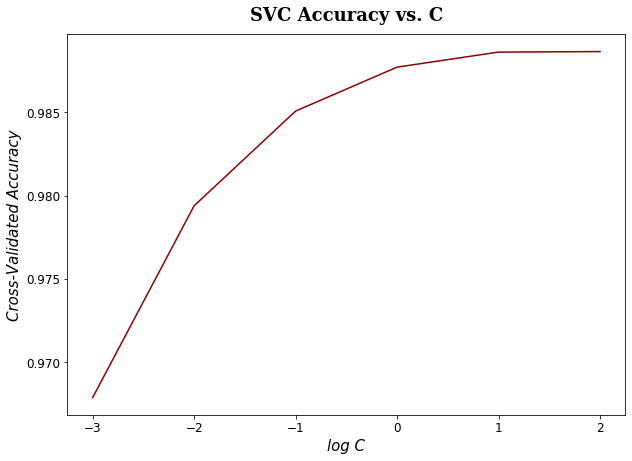

In [29]:
# plot mean accuracy vs. log of C
plt.figure(figsize = (10, 7))
plt.plot(np.log10(c_list), list(svc_acc.values()), color = 'darkred')
plt.title("SVC Accuracy vs. C", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('log C', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated Accuracy', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

plt.show()
plt.close()

In [15]:
# scale predictors for smaller training set and larger (original) test set
scale = StandardScaler().fit(X_train2)
X_tr = scale.transform(X_train2)
X_te = scale.transform(X_test)

# fit linear SVC model to smaller training set (for computational expense) and predict on full test set
# Use optimal C from previous run
svc = svm.SVC(C = 10, kernel = 'linear', random_state = 476, probability = True)\
    .fit(X_tr, y_train2)
svc_metrics = compute_metrics(svc, X_te, y_test)
svc_metrics

{'accuracy': 0.9881522311336822,
 'f1_score': 0.9880622340321049,
 'precision': 0.9881450675309998,
 'recall': 0.9881522311336822,
 'log_loss': 0.061616838877997245,
 'auc': 0.9961377044393014}

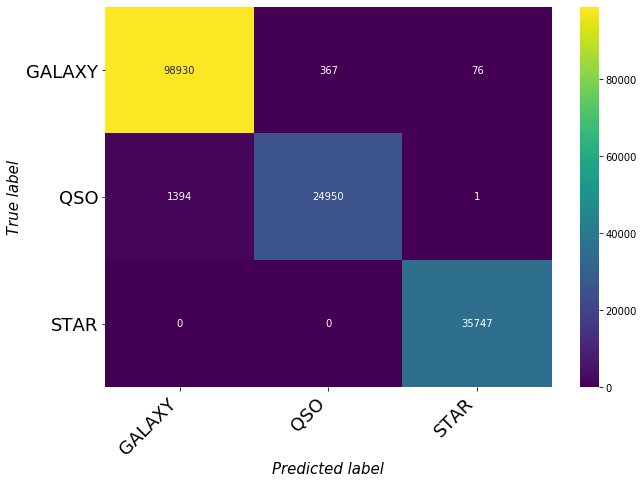

In [12]:
# SVC confusion matrix
svc_cm = confusion_matrix(y_val, svc.predict(X_te))
print_confusion_matrix(svc_cm, ['GALAXY', 'QSO', 'STAR'])

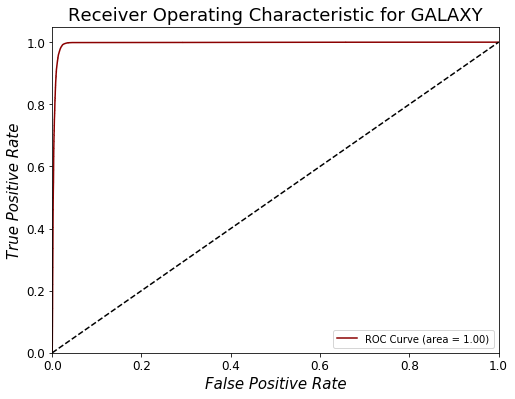

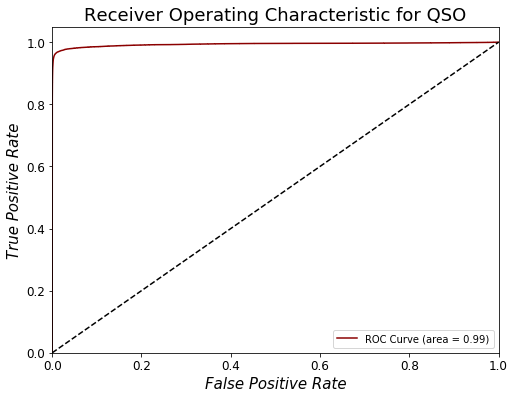

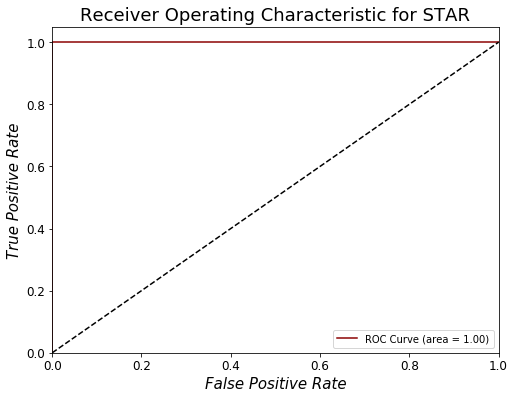

In [13]:
# plot ROC curves
roc_curve_multiclass(svc, X_te, y_val)

### Decision Trees

In [25]:
# simple classification decision tree model
tree = DecisionTreeClassifier(random_state = 476)

In [26]:
# use grid search with CV on smaller training set to find optimal combination of parameters
# parameters tested: max # of tree layers, min # of samples per leaf, max # of features tested per split 
param_grid = dict(max_depth = [10, 25, 50], 
                  min_samples_leaf = [10, 100, 1000], 
                  max_features = [None, 6]
                 )

# mean accuracy across all folds used as scoring metric
grid = GridSearchCV(tree, param_grid, cv = 5, scoring = 'accuracy')
grid.fit(X_train2, y_train2)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=476,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [10, 25, 50], 'max_features': [None, 6],
                         'min_samples_leaf': [10, 100, 100

In [27]:
print(grid.best_score_)  # 99.06% accuracy
print(grid.best_params_)  # max depth = 25, max # of features = None, min # leaf samples = 10
print(grid.best_estimator_)

0.9906295481993002
{'max_depth': 25, 'max_features': None, 'min_samples_leaf': 10}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=476, splitter='best')


In [29]:
# repeat grid search with new grid based on previous results
param_grid2 = dict(max_depth = [20, 25, 30], 
                   min_samples_leaf = [5, 10, 15]
                  )

grid2 = GridSearchCV(tree, param_grid2, cv = 5, scoring = 'accuracy')
grid2.fit(X_train2, y_train2)

print(grid2.best_score_)  
print(grid2.best_params_)  # optimal parameters did not change
print(grid2.best_estimator_)

0.9906295481993002
{'max_depth': 25, 'min_samples_leaf': 10}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=476, splitter='best')


In [16]:
# fit tree to full training set using optimal parameters and predict on full test set
tree = DecisionTreeClassifier(max_depth = 25, min_samples_leaf = 10, random_state = 476)\
    .fit(X_train, y_train)
tree_metrics = compute_metrics(tree, X_test, y_test)
tree_metrics

{'accuracy': 0.9905428421020035,
 'f1_score': 0.9905025467289198,
 'precision': 0.9905183989141023,
 'recall': 0.9905428421020035,
 'log_loss': 0.1580851091797932,
 'auc': 0.9939813122560929}

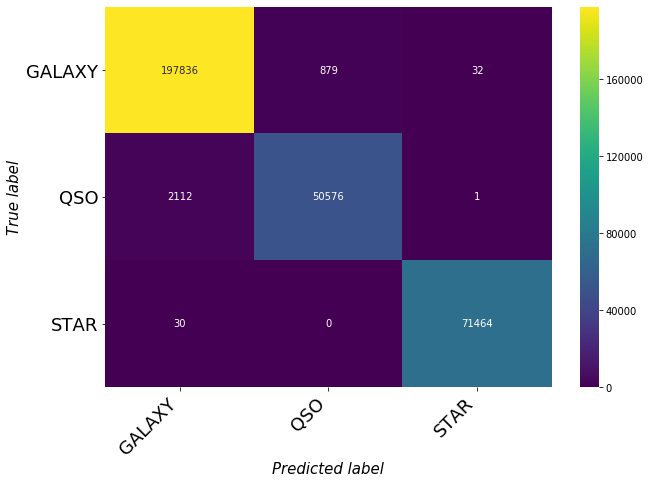

In [42]:
# classification decision tree confusion matrix
tree_cm = confusion_matrix(y_test, tree.predict(X_test))
print_confusion_matrix(tree_cm, ['GALAXY', 'QSO', 'STAR'])

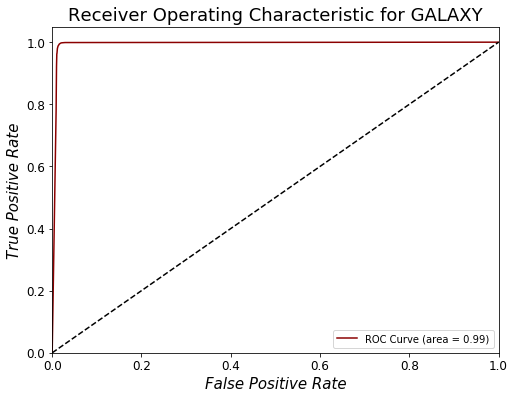

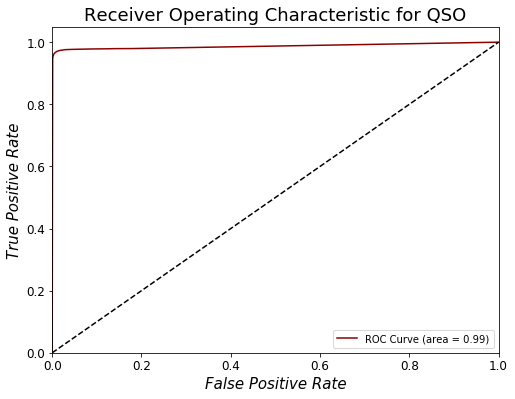

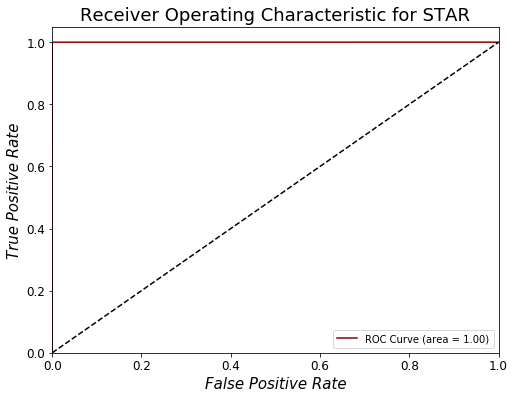

In [43]:
# plot ROC curves
roc_curve_multiclass(tree, X_test, y_test)

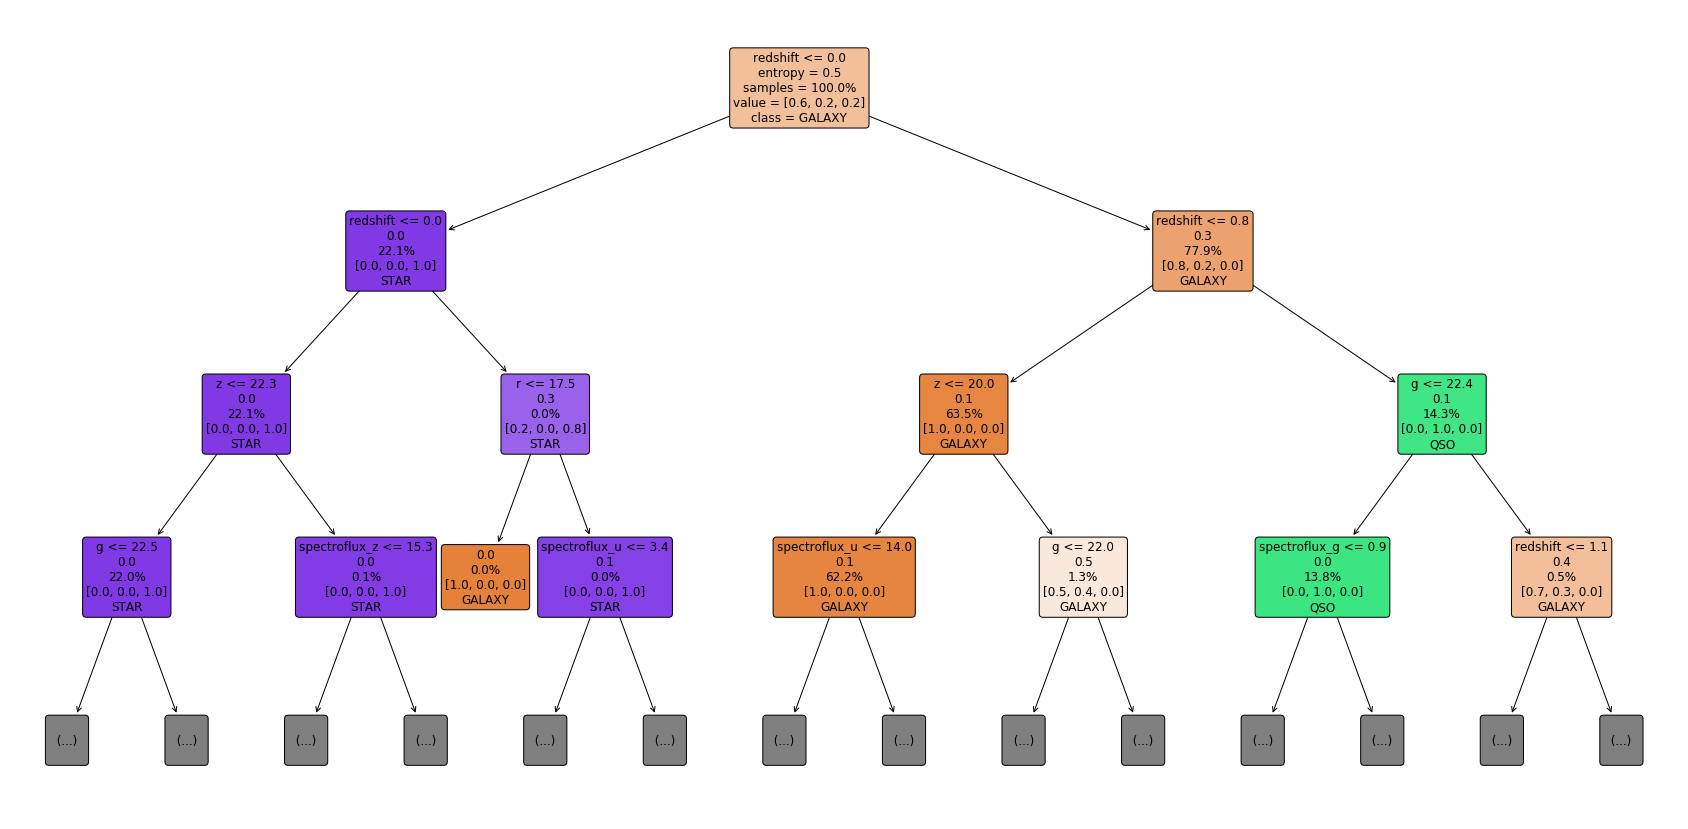

In [22]:
# plot decision tree showing split, entropy, % of samples, fraction in each branch, and class for each node
plt.figure(figsize = (30, 15))
plot_tree(tree, feature_names = list(X.columns), max_depth = 3,
          class_names = list(tree.classes_), filled = True, proportion = True, 
          rounded = True, precision = 1, fontsize = 12, label = 'root')
plt.savefig('tree_all_objects.png', dpi = 100)
plt.show()
plt.close()

In [144]:
# Gini importance for each predictor
dict(zip(X.columns, np.round(tree.feature_importances_, 4)))

{'redshift': 0.9432,
 'u': 0.0013,
 'g': 0.0148,
 'r': 0.0012,
 'i': 0.0014,
 'z': 0.0107,
 'spectroflux_u': 0.0074,
 'spectroflux_g': 0.0173,
 'spectroflux_r': 0.0011,
 'spectroflux_i': 0.0009,
 'spectroflux_z': 0.0007}

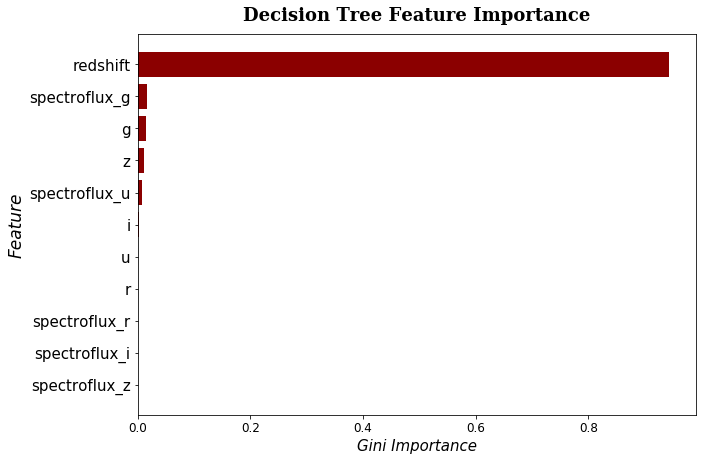

In [14]:
# bar plot of Gini importance for each predictor
feature_imp = pd.DataFrame({'features': X.columns, 'importance': tree.feature_importances_})\
                    .sort_values('importance', ascending = True)

plt.figure(figsize = (10, 7))
plt.barh(feature_imp['features'], feature_imp['importance'], color = 'darkred')
plt.title("Decision Tree Feature Importance", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Gini Importance", fontsize = 15, style = 'italic')
plt.ylabel("Feature", fontsize = 17, style = 'italic')
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 15)

plt.savefig('tree_objects_importance.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

### Bagging and Random Forest

In [17]:
# fit bagging ensemble model to full training set and predict on test set
# using 'max_features = None' with RandomForestClassifier equivalent to bagging
bag = RandomForestClassifier(n_estimators = 100, max_features = None, 
                            random_state = 476, oob_score = True)
bag.fit(X_train, y_train)
bag_metrics = compute_metrics(bag, X_test, y_test)
bag_metrics

{'accuracy': 0.9924070231938811,
 'f1_score': 0.9923682799674325,
 'precision': 0.9924075288200229,
 'recall': 0.9924070231938811,
 'log_loss': 0.06258778103915544,
 'auc': 0.9977316025562405}

In [18]:
# fit random forest model to full training set and predict on test set
# fit a total of 100 trees and randomly select 3 features to choose from at each split
rf = RandomForestClassifier(n_estimators = 100, max_features = 3, 
                            random_state = 476, oob_score = True)
rf.fit(X_train, y_train)
rf_metrics = compute_metrics(rf, X_test, y_test)
rf_metrics

{'accuracy': 0.9925990152664664,
 'f1_score': 0.9925594193901691,
 'precision': 0.9926053967204697,
 'recall': 0.9925990152664664,
 'log_loss': 0.054185312504373535,
 'auc': 0.9979740287907749}

In [195]:
# random forest slightly outperformed bagging
print(bag.oob_score_, rf.oob_score_)

0.9925618555104821 0.992676431424767


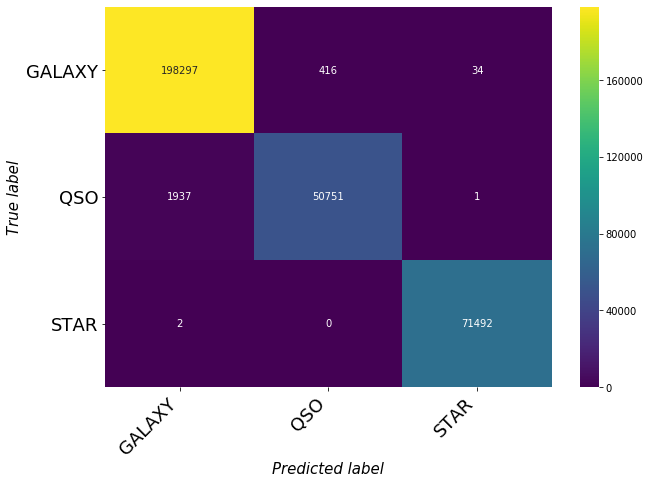

In [17]:
# random forest confusion matrix
rf_cm = confusion_matrix(y_test, rf.predict(X_test))
print_confusion_matrix(rf_cm, ['GALAXY', 'QSO', 'STAR'])

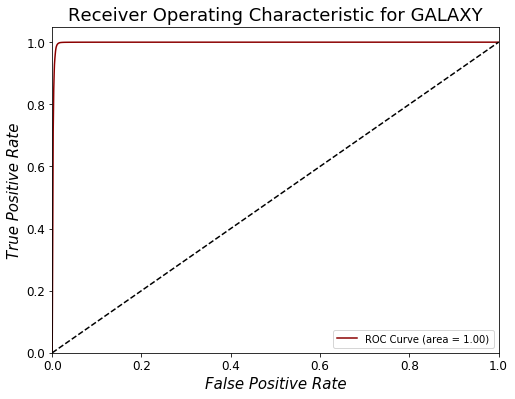

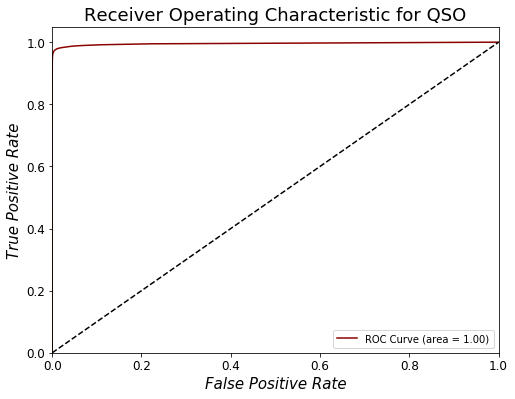

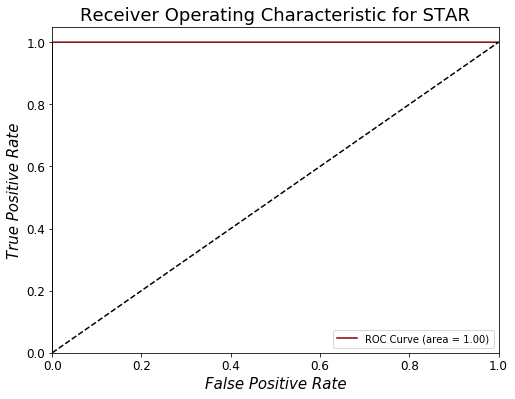

In [204]:
# plot random forest ROC curves
roc_curve_multiclass(rf, X_test, y_test)

In [206]:
# Gini importance for each predictor
dict(zip(X.columns, np.round(rf.feature_importances_, 4)))

{'redshift': 0.5432,
 'u': 0.0225,
 'g': 0.0242,
 'r': 0.0392,
 'i': 0.0647,
 'z': 0.1216,
 'spectroflux_u': 0.0489,
 'spectroflux_g': 0.0693,
 'spectroflux_r': 0.0194,
 'spectroflux_i': 0.0186,
 'spectroflux_z': 0.0285}

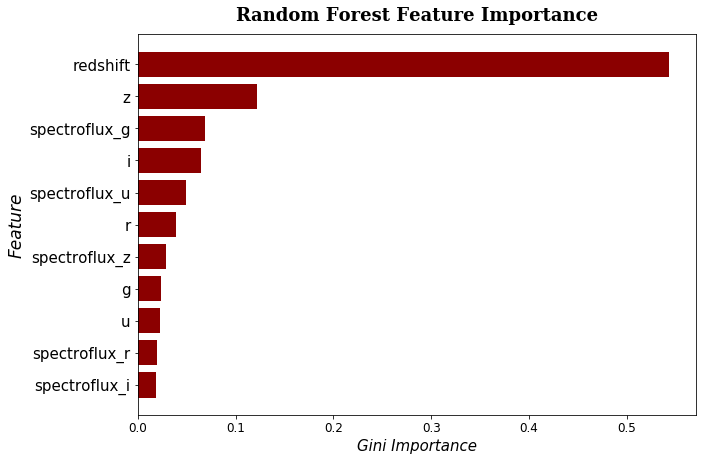

In [26]:
# bar plot of Gini importance for each predictor
feature_imp_rf = pd.DataFrame({'features': X.columns, 'importance': rf.feature_importances_})\
                    .sort_values('importance', ascending = True)

plt.figure(figsize = (10, 7))
plt.barh(feature_imp_rf['features'], feature_imp_rf['importance'], color = 'darkred')
plt.title("Random Forest Feature Importance", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Gini Importance", fontsize = 15, style = 'italic')
plt.ylabel("Feature", fontsize = 17, style = 'italic')
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 15)

plt.savefig('rf_objects_importance.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

### Compare Models

In [19]:
# compile evaluation metrics for all models into dataframe
model_metrics = pd.DataFrame([dummy_metrics, logit_metrics, knn_metrics, 
                              nb_metrics, svc_metrics, tree_metrics, 
                              bag_metrics, rf_metrics], 
                             index = ['dummy', 'logit', 'knn', 'naive_bayes', 'svc', 
                                      'dec_tree', 'bagging', 'random_forest'])
model_metrics

,accuracy,auc,f1_score,log_loss,precision,recall
dummy,0.615,0.500,0.469,13.282,0.379,0.615
logit,0.986,0.996,0.985,0.056,0.985,0.986
knn,0.990,0.993,0.990,0.197,0.990,0.990
naive_bayes,0.808,0.894,0.780,2.051,0.835,0.808
svc,0.988,0.996,0.988,0.062,0.988,0.988
dec_tree,0.991,0.994,0.991,0.158,0.991,0.991
bagging,0.992,0.998,0.992,0.063,0.992,0.992
random_forest,0.993,0.998,0.993,0.054,0.993,0.993


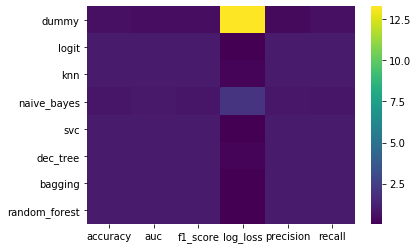

In [21]:
# show previous table as heatmap
sns.heatmap(model_metrics, cmap = 'viridis')
plt.show()
plt.close()

In [25]:
# export to Excel file
model_metrics.to_excel('metrics.xls')

### Best Model

In [236]:
# return to original full dataset and split train-test 50/50 with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, 
                                                    random_state = 476, stratify = y)

In [237]:
# fit best model (random forest) to full dataset (training portion) and predict on test portion
rf_full = RandomForestClassifier(n_estimators = 100, max_features = 3, 
                            random_state = 476, oob_score = True)
rf_full.fit(X_train, y_train)
rf_full_metrics = compute_metrics(rf_full, X_test, y_test)
rf_full_metrics

{'accuracy': 0.9932734690035184,
 'f1_score': 0.9932409473523494,
 'precision': 0.993278552371575,
 'recall': 0.9932734690035184,
 'log_loss': 0.043621862790333664,
 'auc': 0.9984747619694531}

In [238]:
# OOB score for full dataset model
rf_full.oob_score_

0.9932394059149624

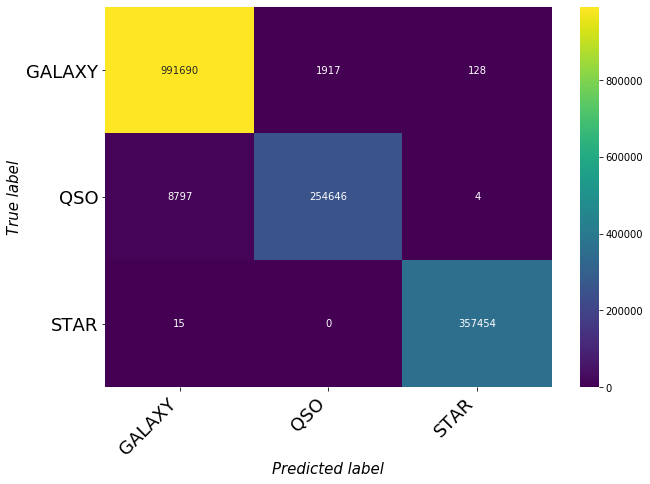

In [239]:
# confusion matrix for full dataset model
rf_full_cm = confusion_matrix(y_test, rf_full.predict(X_test))
print_confusion_matrix(rf_full_cm, ['GALAXY', 'QSO', 'STAR'])

### Flask Application

In [240]:
# use redshift, u-g color, and g-r color as predictors for interactive Flask app
# astronomers commonly indicate color of object by difference between filter magnitudes (e.g. 'u-g color')
# u-g and g-r cover visible portion of spectrum and are commonly used in color-color diagrams
X_app = sp[['redshift']]
X_app['u-g'] = sp['u'] - sp['g']
X_app['g-r'] = sp['g'] - sp['r']

# use object class as response like before
y_app = sp['class']
X_app.head()

,redshift,u-g,g-r
0,-7.844e-04,1.353,-0.115
1,5.623e-02,1.403,0.714
2,1.824e-01,1.487,1.013
3,1.029e-01,1.887,0.927
4,1.570e-01,2.359,1.383


In [241]:
# split train-test 50/50 with stratified sampling
X_app_train, X_app_test, y_app_train, y_app_test = train_test_split(X_app, y_app, test_size = 0.5, 
                                                                    random_state = 476, stratify = y_app)

In [242]:
# fit random forest model to new predictors (training set) and evaluate with test set
# using max_features = 2 here since only 3 predictors
rf_app = RandomForestClassifier(n_estimators = 100, max_features = 2, 
                                random_state = 476, oob_score = True)
rf_app.fit(X_app_train, y_app_train)
rf_app_metrics = compute_metrics(rf_app, X_app_test, y_app_test)
rf_app_metrics

{'accuracy': 0.9906982995086864,
 'f1_score': 0.9906600480555426,
 'precision': 0.9906720590215888,
 'recall': 0.9906982995086864,
 'log_loss': 0.09021297901194489,
 'auc': 0.9968137477959457}

In [253]:
# example user input: redshift = 0, u-g color = 0, g-r color = 0
prediction = rf_app.predict([[0, 0, 0]])[0]
prediction  # app predicts star

'STAR'

In [243]:
# export model as binary object for app
pickle.dump(rf_app, open('rf_app_object_model.pickle', 'wb'))